In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas.api.types import CategoricalDtype
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
import os
import matplotlib.pyplot as plt 
import plotly.express as px
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ncl_pm10 = pd.read_csv("/content/drive/MyDrive/ncl_pm10_forecast.csv")

In [ ]:
ncl_pm10

,Variable,Timestamp,Value
0,PM10,2019-07-01 00:00:00,5.424667
1,PM10,2019-07-01 00:00:00,3.492322
2,PM10,2019-07-01 00:00:00,6.977382
3,PM10,2019-07-01 00:00:00,5.381542
4,PM10,2019-07-01 00:00:00,1.330339
...,...,...,...
233070,PM10,2019-12-31 23:00:00,17.798583
233071,PM10,2019-12-31 23:00:00,28.500179
233072,PM10,2019-12-31 23:00:00,15.250033
233073,PM10,2019-12-31 23:00:00,7.856167


In [ ]:
#ncl_pm10 = ncl_pm10.loc[ncl_pm10['Variable'] == 'PM10']
ncl_pm10 = ncl_pm10.drop('Variable', 1)
ncl_pm10

,Timestamp,Value
0,2019-07-01 00:00:00,5.424667
1,2019-07-01 00:00:00,3.492322
2,2019-07-01 00:00:00,6.977382
3,2019-07-01 00:00:00,5.381542
4,2019-07-01 00:00:00,1.330339
...,...,...
233070,2019-12-31 23:00:00,17.798583
233071,2019-12-31 23:00:00,28.500179
233072,2019-12-31 23:00:00,15.250033
233073,2019-12-31 23:00:00,7.856167


In [ ]:
df = ncl_pm10.rename(columns = {"Timestamp":"ds","Value":"y"}) 
df['day'] = pd.to_datetime(df['ds']).dt.date
df = df.groupby(["day"])['y'].mean().reset_index()
df = df.rename(columns = {"day":"ds","Value":"y"}) 
df

,ds,y
0,2019-07-01,4.399093
1,2019-07-02,5.884503
2,2019-07-03,6.050297
3,2019-07-04,9.317409
4,2019-07-05,6.963904
...,...,...
179,2019-12-27,20.774130
180,2019-12-28,21.141221
181,2019-12-29,8.749873
182,2019-12-30,8.699011


In [ ]:
## complete FB_Prophet fitting, plotting ETS components from model, finding performance metrics using cross validation and returing horizon based cross validation metrics on 
## a single training dataset -  cross validated on testing data only
def predict_FB_step1(df,break_index, per):
    df_FB = df[:break_index]
    print('start and end date of training dataset :', df_FB['ds'].head(1),df_FB['ds'].tail(1))
    
    test = df[break_index:break_index+per]
    print('start and end date of testing dataset :', test['ds'].head(1),test['ds'].tail(1))  
    print(test)
    
    from fbprophet import Prophet
    #The Prophet class (model)
    fbp = Prophet(daily_seasonality = True) 
    #Fit the model 
    fbp.fit(df_FB)
    
    # We need to specify the number of days in future
    # We'll be predicting the full 2021 stock prices
    fut = fbp.make_future_dataframe(periods=per) 
    forecast = fbp.predict(fut)
    
    from fbprophet.plot import plot_plotly, plot_components_plotly
    # A better plot than the simple matplotlib
    forecast_plot = plot_plotly(fbp, forecast)
    forecast_plot.show()
    
    fbp.plot(forecast)
    plt.title("Prediction of air quality")
    plt.xlabel("Date")
    plt.ylabel("value")
    plt.show()
    
    fbp.plot_components(forecast)
    plt.show()
    
    from statsmodels.tools.eval_measures import rmse
    predictions = forecast.tail(per)
    
    #predictions = forecast.iloc[-per:]['yhat']
    print(predictions['yhat'],test['y'])
    

    
    
    # Plot predictions against known values
    import matplotlib.ticker as ticker
    #formatter = ticker.StrMethodFormatter('{x:,.0f}')
    title = 'EURUSD forecast using FB Prophet'
    ylabel='Dollars FX'
    xlabel=''
    ax = df['y'].plot(legend=True,figsize=(12,6),title=title)
    predictions['yhat'].plot(legend=True)
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    #ax.yaxis.set_major_formatter(formatter);
    
    from fbprophet.diagnostics import cross_validation,performance_metrics
    from fbprophet.plot import plot_cross_validation_metric
    
    length = round(len(df_FB)/24,0)
    print(length)
    
    # Initial length of df_FB training period
    initial = 80
    initial = str(initial) + ' days'
    # Fold every length of df_FB years
    period = 10
    period = str(period) + ' days'
    # Forecast per days into the future
    horizon = per
    horizon = str(horizon) + ' days'
    #, 
    df_cv = cross_validation(fbp,initial=initial, period=period,  horizon = horizon)
    df_cv
    performance_metrics = performance_metrics(df_cv)
    print(performance_metrics)
    
    plot_cross_validation_metric(df_cv, metric='rmse');
    plt.title("rmse metric")
    plt.show()
    
    plot_cross_validation_metric(df_cv, metric='mape');
    plt.title("mape metric")
    plt.show()
    return performance_metrics

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


start and end date of training dataset : 0    2019-07-01
Name: ds, dtype: object 129    2019-11-07
Name: ds, dtype: object
start and end date of testing dataset : 130    2019-11-08
Name: ds, dtype: object 159    2019-12-07
Name: ds, dtype: object
             ds          y
130  2019-11-08   6.510866
131  2019-11-09  19.157814
132  2019-11-10   7.304429
133  2019-11-11   5.386485
134  2019-11-12   4.132458
135  2019-11-13   8.923192
136  2019-11-14   6.325394
137  2019-11-15   8.431430
138  2019-11-16   9.166174
139  2019-11-17   6.298120
140  2019-11-18   7.041969
141  2019-11-19  14.278190
142  2019-11-20  23.186362
143  2019-11-21  12.755613
144  2019-11-22  15.112312
145  2019-11-23  24.021472
146  2019-11-24  49.858044
147  2019-11-25  32.482457
148  2019-11-26  36.598963
149  2019-11-27  77.697485
150  2019-11-28   8.534002
151  2019-11-29   8.046149
152  2019-11-30  17.262739
153  2019-12-01   9.625648
154  2019-12-02   6.475536
155  2019-12-03  11.499681
156  2019-12-04  10.0383

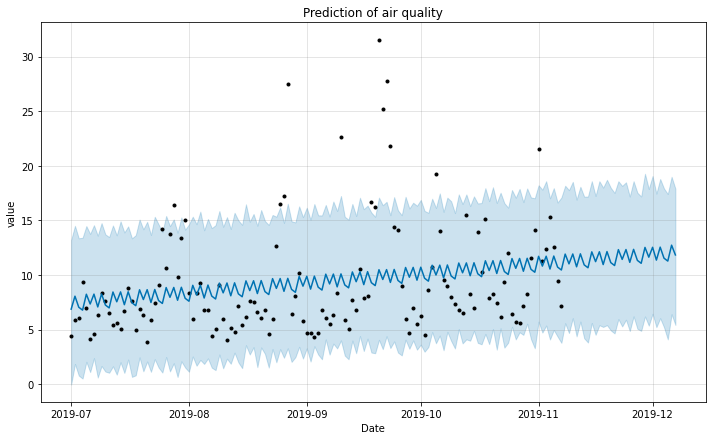

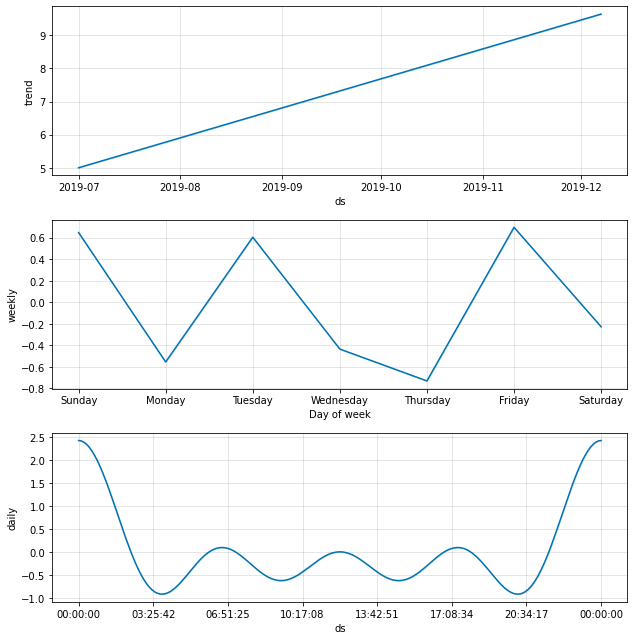

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-09-28 00:00:00 and 2019-10-08 00:00:00


130    11.910648
131    11.015923
132    11.920227
133    10.747144
134    11.935200
135    10.925320
136    10.658463
137    12.114896
138    11.220170
139    12.124475
140    10.951391
141    12.139447
142    11.129567
143    10.862710
144    12.319143
145    11.424418
146    12.328722
147    11.155639
148    12.343695
149    11.333815
150    11.066958
151    12.523391
152    11.628665
153    12.532970
154    11.359886
155    12.547942
156    11.538063
157    11.271205
158    12.727638
159    11.832913
Name: yhat, dtype: float64 130     6.510866
131    19.157814
132     7.304429
133     5.386485
134     4.132458
135     8.923192
136     6.325394
137     8.431430
138     9.166174
139     6.298120
140     7.041969
141    14.278190
142    23.186362
143    12.755613
144    15.112312
145    24.021472
146    49.858044
147    32.482457
148    36.598963
149    77.697485
150     8.534002
151     8.046149
152    17.262739
153     9.625648
154     6.475536
155    11.499681
156    10.038343
157 


   horizon        mse      rmse       mae      mape     mdape  coverage
0   3 days  33.567994  5.793789  5.472760  0.843349  0.829651  0.666667
1   4 days  41.157037  6.415375  6.180013  1.070261  1.053102  0.500000
2   5 days  34.573295  5.879906  5.508942  0.879619  0.804141  0.666667
3   6 days  21.121844  4.595851  4.141354  0.625990  0.360551  0.833333
4   7 days  19.209424  4.382856  4.029039  0.389043  0.356061  0.833333
5   8 days  17.156117  4.141994  3.463665  0.329480  0.277777  0.833333
6   9 days  16.939804  4.115799  3.295366  0.307426  0.269840  0.833333
7  10 days  10.607382  3.256898  2.641050  0.248287  0.188984  1.000000
8  11 days  16.996597  4.122693  3.757490  0.414252  0.468827  1.000000
9  12 days  22.519785  4.745502  4.652978  0.546975  0.598364  1.000000
10 13 days  25.615429  5.061169  4.994771  0.664611  0.598364  0.833333
11 14 days  34.043614  5.834691  5.714983  0.831389  0.834788  0.666667
12 15 days  27.538369  5.247701  4.696774  0.679537  0.781897  

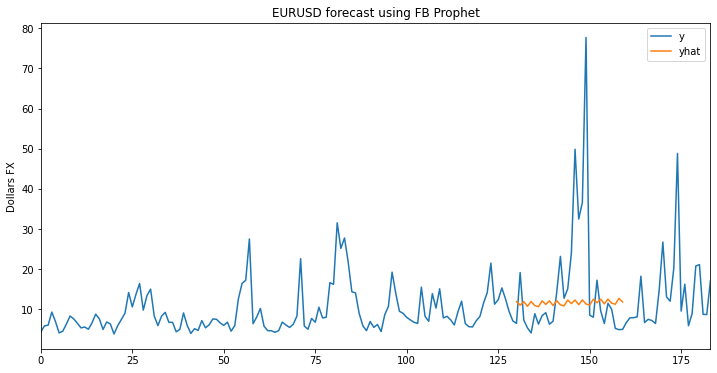

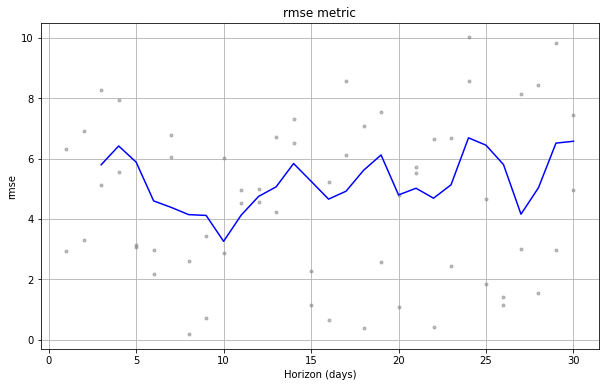

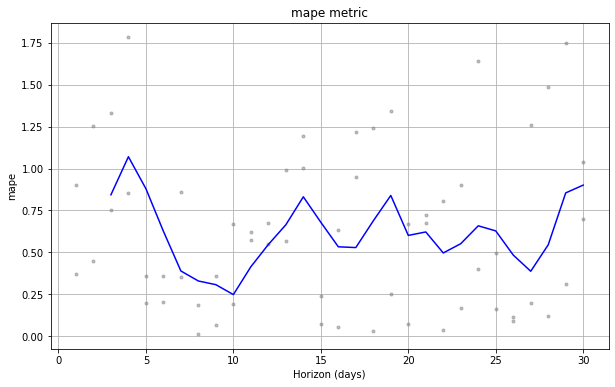

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,33.567994,5.793789,5.472760,0.843349,0.829651,0.666667
1,4 days,41.157037,6.415375,6.180013,1.070261,1.053102,0.500000
2,5 days,34.573295,5.879906,5.508942,0.879619,0.804141,0.666667
3,6 days,21.121844,4.595851,4.141354,0.625990,0.360551,0.833333
4,7 days,19.209424,4.382856,4.029039,0.389043,0.356061,0.833333
5,8 days,17.156117,4.141994,3.463665,0.329480,0.277777,0.833333
6,9 days,16.939804,4.115799,3.295366,0.307426,0.269840,0.833333
7,10 days,10.607382,3.256898,2.641050,0.248287,0.188984,1.000000
8,11 days,16.996597,4.122693,3.757490,0.414252,0.468827,1.000000
9,12 days,22.519785,4.745502,4.652978,0.546975,0.598364,1.000000


In [ ]:
predict_FB_step1(df,130,30)